# 01_data_preparation.ipynb
- Ce notebook réalise la préparation des données pour le système de recommandation (P10).
- Il produit deux DataFrames essentiels :
   - df_articles : métadonnées + embeddings réduits
   - df : clics utilisateurs enrichis par les métadonnées
# 1 - Préparation des données articles
-  Objectif : préparer un dataset "content-based" basé sur les articles eux-mêmes.
## 1.1 - Chargement des métadonnées et embeddings
- Cette section prépare le DataFrame `df_articles` en associant à chaque article ses métadonnées et son vecteur d'embedding (contenu sémantique).
   - Ce DataFrame sera utilisé dans les approches de type Content-Based Filtering pour recommander des articles similaires sur la base du contenu.
### 1.1.1 - Import des fonctions utiles
   - On importation des fonctions de prétraitement depuis /src/
   - Installation automatique des dépendances du projet (requirements.txt)
   - Détection de l’environnement GPU/CPU pour le PCA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import sys
import os
import numpy as np
from sklearn.decomposition import PCA


# Détection du chemin racine du projet
project_root = os.path.abspath("..")  # remonte d'un cran depuis notebooks/
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
# installation automatique des requirements
from utils.env_setup import install_requirements
install_requirements("requirements.txt")

# Imports des fonctions de traitement
from data_preprocessing import (
    load_metadata,              
    load_embeddings_pickle,     
    attach_embeddings,          
    load_all_data,              
    reduce_embeddings           
)

from utils.utils import save_df
from utils.validators import check_column_presence 

# Détection de cuML pour PCA GPU (sinon on utilisera sklearn via reduce_embeddings)
try:
    from cuml.decomposition import PCA as cuPCA
    use_gpu = True
except ModuleNotFoundError:
    use_gpu = False
    # reduce_embeddings() utilisera sklearn.decomposition.PCA

📦 Installation des dépendances depuis c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\requirements.txt ...


## 1.2 - Définition des chemins
- Définition des chemins vers les fichiers sources (.csv, .pickle), ainsi que des chemins de sortie pour la sauvegarde

In [3]:
data_path       = os.path.join(project_root, "data")
metadata_path   = os.path.join(data_path, "articles_metadata.csv")
embeddings_path = os.path.join(data_path, "articles_embeddings.pickle")
output_path     = os.path.join(project_root, "outputs", "df_articles.parquet")

## 1.3 - Chargement des métadonnées
- Lecture du fichier CSV contenant les infos de base sur les articles (id, titre, etc.)

In [4]:
# Chargement des métadonnées
df_meta = load_metadata(metadata_path)

In [5]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


## 1.4 - Chargement des embeddings bruts
- Chargement du fichier .pickle contenant les vecteurs sémantiques

In [6]:
embeddings_raw = load_embeddings_pickle(embeddings_path)
print("Shape embeddings bruts :", embeddings_raw.shape)

Shape embeddings bruts : (364047, 250)


## 1.5 - Réduction de dimension des embeddings
- Objectif : compression des vecteurs pour réduire la taille et rester dans les limites Azure
- Utilisation de cuML (GPU) si dispo, sinon fallback sur sklearn (CPU)
- Taux de variance expliquée ciblé : 95 %

In [7]:
# Objectif : conserver 95 % de la variance
var_explained = 0.95

# 📁 Définition du chemin de sortie .npz
npz_output_path = os.path.join(project_root, "outputs", "articles_embeddings_compressed.npz")

if use_gpu:
    # ⚡️ PCA GPU via cuML (n'accepte pas n_components < 1)
    pca_gpu = cuPCA(n_components=80)
    emb_gpu_full = pca_gpu.fit_transform(embeddings_raw)
    ratios_gpu = pca_gpu.explained_variance_ratio_.cumsum()
    k = int((ratios_gpu >= var_explained).argmax()) + 1
    embeddings_reduced = emb_gpu_full[:, :k]

    print(f"GPU: {k} composantes gardées pour atteindre {var_explained*100:.0f} % de variance")

else:
    # 🧠 PCA CPU via scikit-learn
    pca_cpu = PCA(n_components=var_explained)
    embeddings_reduced = pca_cpu.fit_transform(embeddings_raw)

    print(f"CPU: {pca_cpu.n_components_} composantes gardées pour atteindre {var_explained*100:.0f} % de variance")

# 💾 Sauvegarde des embeddings réduits dans un fichier .npz
np.savez(npz_output_path, embeddings=embeddings_reduced)
print(f"[✔] Embeddings réduits sauvegardés dans : {npz_output_path}")


CPU: 52 composantes gardées pour atteindre 95 % de variance
[✔] Embeddings réduits sauvegardés dans : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P10\2-python\outputs\articles_embeddings_compressed.npz


### 1.5.1 - Projection PCA des articles (filtrée sur les 10 catégories les plus fréquentes)
- Donne du sens visuel aux embeddings, montre que le modèle pourra discriminer les contenus par thème

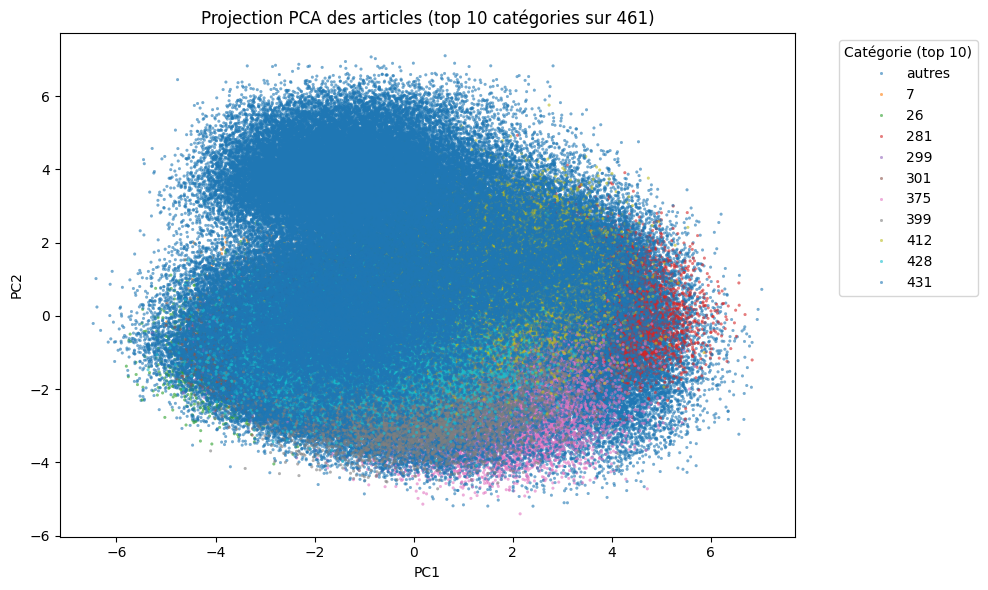

In [51]:
from sklearn.decomposition import PCA

# Projection en 2D des embeddings compressés
pca_visu = PCA(n_components=2)
embeddings_2D = pca_visu.fit_transform(np.vstack(df_articles["embedding"].values))
df_articles["x"] = embeddings_2D[:, 0]
df_articles["y"] = embeddings_2D[:, 1]

# Top 10 des catégories les plus fréquentes
top_cats = df_articles["category_id"].value_counts().head(10).index
df_articles["category_top"] = df_articles["category_id"].where(df_articles["category_id"].isin(top_cats), other="autres")

# Nombre total de catégories
n_cat_total = df_articles["category_id"].nunique()

# Affichage
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_articles,
    x="x", y="y",
    hue="category_top",
    palette="tab10",
    alpha=0.6,
    s=4,
    # marker='x',
    edgecolor=None
)
plt.title(f"Projection PCA des articles (top 10 catégories sur {n_cat_total})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Catégorie (top 10)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 1.5.2 - Courbe de variance expliquée par la PCA
- motive la conservation de 52 composantes (95 % de variance)

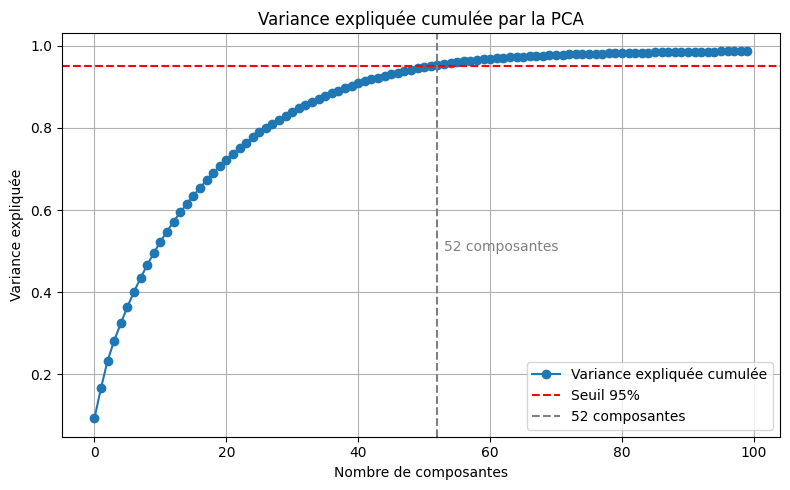

In [33]:
# Utilisation embeddings_raw d'origine, non réduit
# PCA sur les embeddings bruts
pca_full = PCA(n_components=100)
pca_full.fit(embeddings_raw)

# Variance expliquée cumulée
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Trouver le nombre minimal de composantes pour atteindre 95 %
k_95 = np.argmax(cumsum >= 0.95) + 1

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(cumsum, marker="o", label="Variance expliquée cumulée")
plt.axhline(y=0.95, color="r", linestyle="--", label="Seuil 95%")
plt.axvline(x=k_95, color="gray", linestyle="--", label=f"{k_95} composantes")

# Annotation
plt.text(k_95 + 1, 0.5, f"{k_95} composantes", color="gray", fontsize=10)

# Mise en forme
plt.title("Variance expliquée cumulée par la PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Ce graphique montre qu’il suffit de 52 composantes pour conserver 95 % de l’information des embeddings. Cela justifie la réduction de dimension opérée pour alléger les calculs, notamment dans un contexte Azure serverless.
## 1.6 - Attachement des embeddings réduits aux métadonnées
- Association de chaque vecteur compressé à l’article correspondant
- Création du DataFrame final `df_articles`

In [8]:
df_articles = attach_embeddings(df_meta, embeddings_reduced)

## 1.7 - Sauvegarde du DataFrame enrichi
- Sauvegarde en format `.parquet` compressé pour efficacité

In [10]:
save_df(df = df_articles, path = output_path, format = "parquet")

# 2 - Préparation des données de clics et construction du DataFrame global
- Objectif : fusionner les clics avec les métadonnées pour un système de type "collaboratif".
## 2.1 - Chargement des clics et des métadonnées brutes
- Chargement de :
    - `df_clicks_full` : concaténation automatique des 385 fichiers `clicks_hour_XXX.csv`
    - `df_clicks_sample` : version allégée pour tests rapides
    - `df_articles_metadata` : copie brute sans embeddings, uniquement utilisée pour vérif

In [11]:
# Appel de la fonction de chargement global
df_clicks_full, df_clicks_sample, df_articles_metadata = load_all_data(data_path = data_path)

## 2.2 - Fusion des clics avec les articles (sans embeddings)
- Nettoyage préalable : suppression de la colonne `embedding`
- Vérification de la présence des colonnes clés pour la jointure
- Jointure par `article_id` pour enrichir les logs utilisateurs

In [12]:
df_articles_simple = df_articles.drop(columns = ["embedding"])
df_clicks_full    = df_clicks_full.rename(columns = {"click_article_id": "article_id"})

In [13]:
# Vérification des colonnes clés
check_column_presence(df_clicks_full,      ["article_id"], "df_clicks_full")
check_column_presence(df_articles_simple, ["article_id"], "df_articles_simple")

In [14]:
# Fusion propre
df = df_clicks_full.merge(df_articles_simple, on = "article_id", how = "left")

## 2.2.1 - Enrichissement temporel (timestamp → jour, heure, mois)

In [15]:
df["click_timestamp"] = pd.to_datetime(df["click_timestamp"], unit = "ms", errors = "coerce")
df["hour"] = df["click_timestamp"].dt.hour
df["day"] = df["click_timestamp"].dt.day_name()
df["month"] = df["click_timestamp"].dt.to_period("M")

## 2.2.2 - Visualisations exploratoires sur les clics

In [16]:
# Top 10 articles les plus cliqués
top_articles = (
    df["article_id"].value_counts().head(10).reset_index().rename(
        columns={"index": "article_id", "article_id": "nb_clicks"})
)
print("Top 10 articles les plus cliqués :\n", top_articles)

Top 10 articles les plus cliqués :
    nb_clicks  count
0     160974  37213
1     272143  28943
2     336221  23851
3     234698  23499
4     123909  23122
5     336223  21855
6      96210  21577
7     162655  21062
8     183176  20303
9     168623  19526


C:\Users\motar\AppData\Local\Temp\ipykernel_32564\913811548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\motar\AppData\Local\Temp\ipykernel_32564\913811548.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


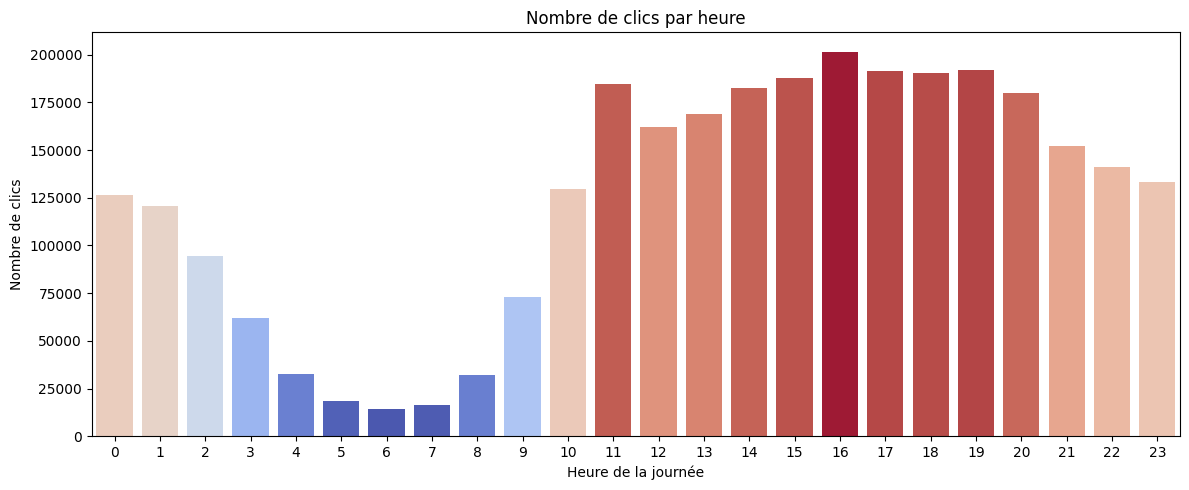

In [52]:
# Clics par heure
clicks_by_hour = df["hour"].value_counts().sort_index()
values = clicks_by_hour.values
norm = plt.Normalize(values.min(), values.max())
colors = cm.coolwarm(norm(values))

plt.figure(figsize=(12, 5))
sns.barplot(
    x=clicks_by_hour.index,
    y=values,
    palette=colors
)
plt.title("Nombre de clics par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de clics")
plt.tight_layout()
plt.show()

L’activité des utilisateurs est concentrée entre 10h et 20h, avec un pic à 16h. Cela peut guider le moment idéal pour proposer ou mettre en avant des articles

C:\Users\motar\AppData\Local\Temp\ipykernel_32564\2212752890.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clicks_by_day.index, y=values, palette=colors)
C:\Users\motar\AppData\Local\Temp\ipykernel_32564\2212752890.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=clicks_by_day.index, y=values, palette=colors)


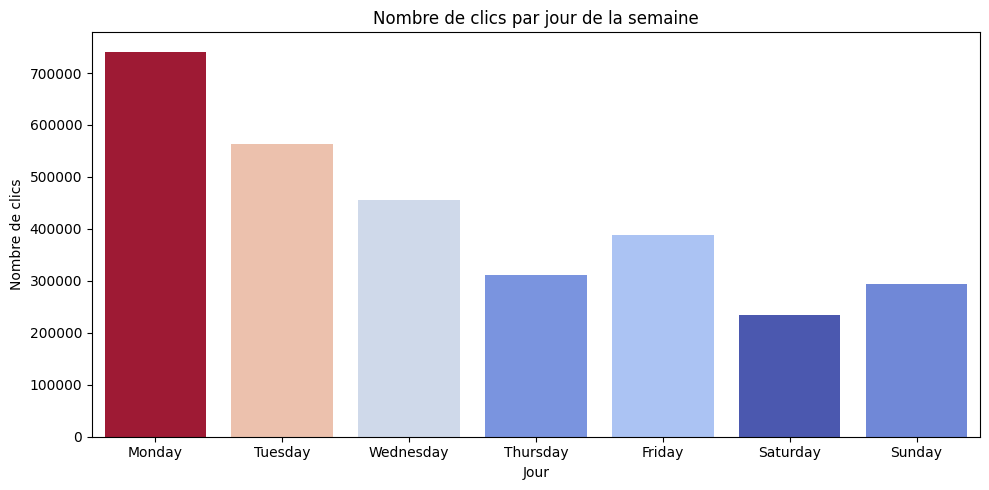

In [18]:
# Clics par jour de la semaine 
clicks_by_day = df["day"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

# Normalisation des valeurs pour la colormap
values = clicks_by_day.values
norm = plt.Normalize(values.min(), values.max())
colors = cm.coolwarm(norm(values))

# Affichage du graphique
plt.figure(figsize=(10, 5))
sns.barplot(x=clicks_by_day.index, y=values, palette=colors)
plt.title("Nombre de clics par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre de clics")
plt.tight_layout()
plt.show()

L’activité est très forte en début de semaine, notamment le lundi, puis décroît jusqu’au week-end. Cela peut orienter la stratégie de diffusion des contenus les plus visibles

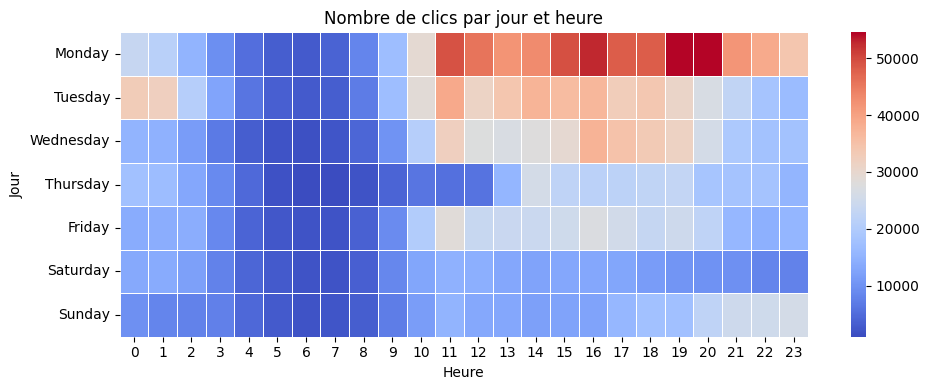

In [ ]:
# Heatmap clics par jour & heure
# Utile pour détecter des moments forts d'engagement
pivot = df.pivot_table(index="day", columns="hour", values="user_id", aggfunc="count").reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.figure(figsize=(10, 4))
sns.heatmap(pivot, cmap="coolwarm", linewidths=0.5)
plt.title("Nombre de clics par jour et heure")
plt.xlabel("Heure")
plt.ylabel("Jour")
plt.tight_layout()
plt.show()

Cette heatmap confirme que l’activité est concentrée en journée, surtout les après-midis de semaine, avec un pic marqué le lundi.

C:\Users\motar\AppData\Local\Temp\ipykernel_32564\128311035.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette="Blues_r")


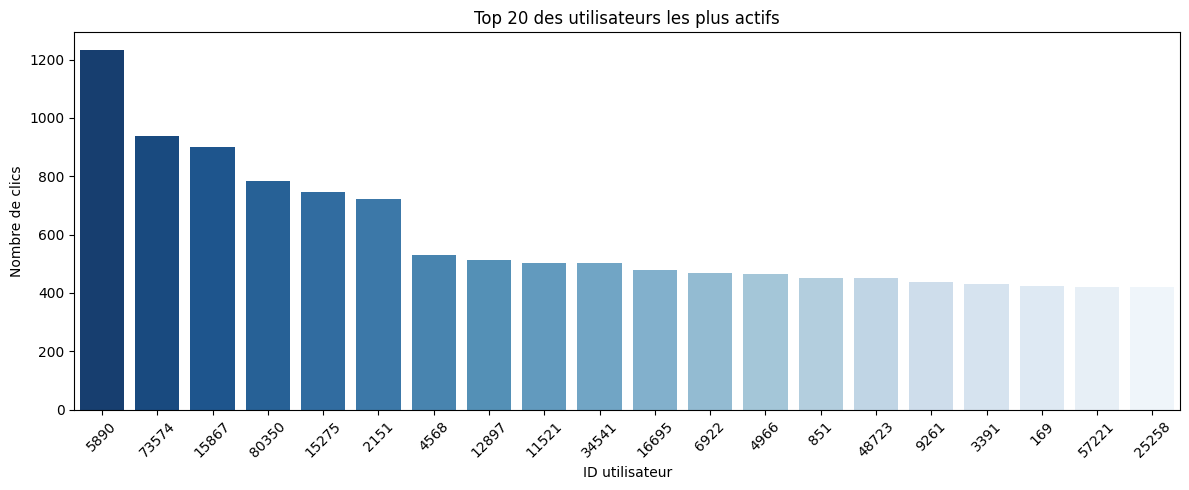

In [19]:
# Nombre de clics par utilisateur
# Identifier les utilisateurs les plus actifs / inactifs (utile pour CF)
top_users = df["user_id"].value_counts().head(20)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette="Blues_r")
plt.title("Top 20 des utilisateurs les plus actifs")
plt.xlabel("ID utilisateur")
plt.ylabel("Nombre de clics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Une poignée d’utilisateurs concentre l’essentiel de l’activité, ce qui est typique des systèmes de recommandation collaboratifs (CF)
- Cela confirme que seule une petite minorité d’utilisateurs génère une majorité de l’activité (effet Pareto)

C:\Users\motar\AppData\Local\Temp\ipykernel_32564\1300276849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


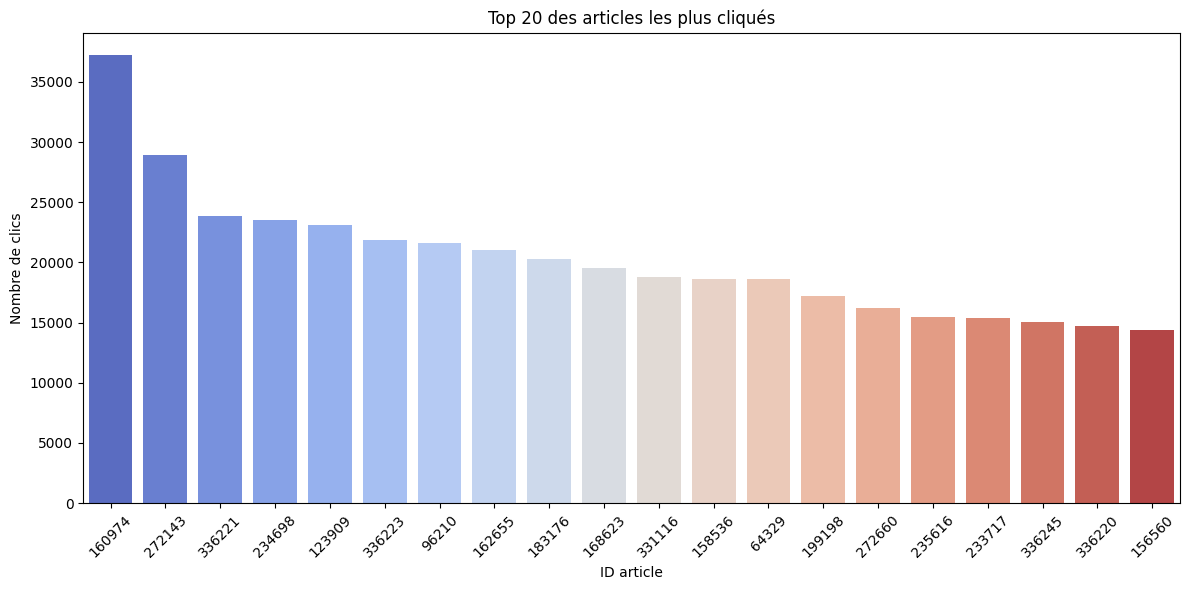

In [20]:
# Top 20 des articles les plus cliqués
top_articles_20 = df["article_id"].value_counts().head(20).reset_index()
top_articles_20.columns = ["article_id", "nb_clicks"]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_articles_20["article_id"].astype(str),
    y=top_articles_20["nb_clicks"],
    palette=sns.color_palette("coolwarm", n_colors=20)
)
plt.title("Top 20 des articles les plus cliqués")
plt.xlabel("ID article")
plt.ylabel("Nombre de clics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Certains articles captent massivement l’attention, ce qui justifie la mise en place d’un modèle capable de recommander aussi des contenus moins populaires mais pertinents.

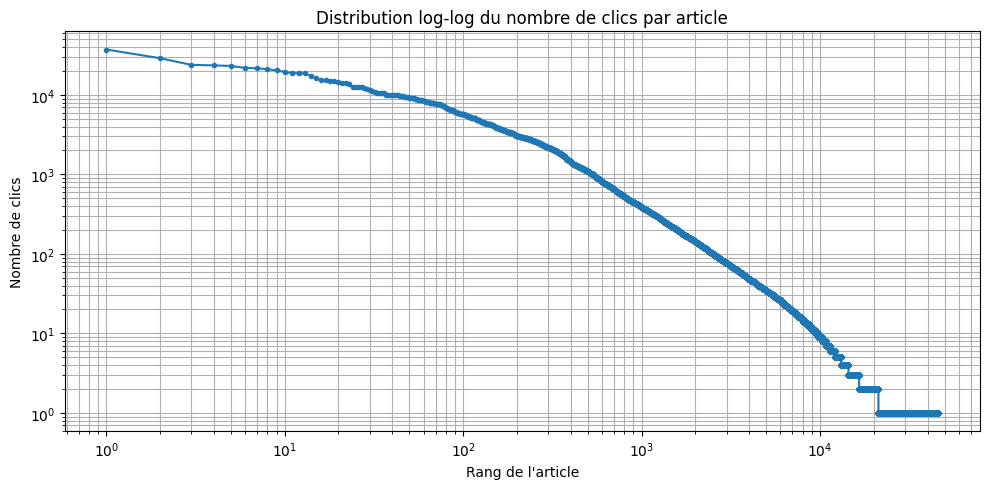

In [38]:
clicks_per_article = df["article_id"].value_counts()
plt.figure(figsize=(10, 5))
plt.loglog(range(1, len(clicks_per_article)+1), clicks_per_article.values, marker=".")
plt.title("Distribution log-log du nombre de clics par article")
plt.xlabel("Rang de l'article")
plt.ylabel("Nombre de clics")
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

La distribution log-log confirme un effet long tail : très peu d’articles concentrent l’attention, tandis que la majorité reste peu consultée.
## 2.3 - Sauvegarde du DataFrame global
- Sauvegarde du fichier complet `df.parquet`

In [23]:
df_output_path = os.path.join(project_root, "outputs", "df.parquet")
save_df(df = df, path = df_output_path, format = "parquet")

## 2.4 - Échantillonnage à 1 % pour tests rapides
- Sauvegarde d’un petit sous-ensemble (`df_sample.pkl`) utile pour prototypage local

In [24]:
df_sample = df.sample(frac = 0.01, random_state = 70)
sample_output_path = os.path.join(project_root, "outputs", "df_sample.pkl")
os.makedirs(os.path.dirname(sample_output_path), exist_ok = True)
df_sample.to_pickle(sample_output_path)

# 3 - Affichages rapides pour vérification
- Vérification de la forme des DataFrames
- Aperçu rapide du contenu

In [25]:
print("df_articles :", df_articles.shape)
print("df :",          df.shape)
print("df_sample :",   df_sample.shape)

df_articles : (364047, 6)
df : (2988181, 19)
df_sample : (29882, 19)


In [26]:
print("\nInfos df :")
df.info()


Infos df :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   session_id           object        
 2   session_start        object        
 3   session_size         object        
 4   article_id           object        
 5   click_timestamp      datetime64[ns]
 6   click_environment    object        
 7   click_deviceGroup    object        
 8   click_os             object        
 9   click_country        object        
 10  click_region         object        
 11  click_referrer_type  object        
 12  category_id          int64         
 13  created_at_ts        int64         
 14  publisher_id         int64         
 15  words_count          int64         
 16  hour                 int32         
 17  day                  object        
 18  month                period[M]     
dtypes: dateti

In [27]:
df_articles.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   session_id           object        
 2   session_start        object        
 3   session_size         object        
 4   article_id           object        
 5   click_timestamp      datetime64[ns]
 6   click_environment    object        
 7   click_deviceGroup    object        
 8   click_os             object        
 9   click_country        object        
 10  click_region         object        
 11  click_referrer_type  object        
 12  category_id          int64         
 13  created_at_ts        int64         
 14  publisher_id         int64         
 15  words_count          int64         
 16  hour                 int32         
 17  day                  object        
 18  month                period[M]     
dtypes: datetime64[ns](1),